### 2 in the title means it is based on the simulated dataset

#### Setup 

In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

config = Dataset_load.load_config()
colors = config["colors"]["three"]
import ast

colors[1] = ast.literal_eval(colors[1])
colors[2] = ast.literal_eval(colors[2])
colors[3] = ast.literal_eval(colors[3])

#import seaborn as sns


alpha_nui = 0.99
alpha_st = 0.99
legendsscatter = ["Asimov w/o nui.", "Asimov with nui."]
legends = ["", ""]

alpha_rnd = 0.2
alpha_rnd_nui = 0.2

nbins = 20

TypeError: list indices must be integers or slices, not str

In [ ]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6, color = 'red'):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label, color = color)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j], 
                        color = colors [j])
            except:
                pass

    plt.tight_layout()
    return fig

markersize = [6,10, 10]


def plot_asimov_spectrum(fig, ax):
    model = dataset_asimov_N.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[1],
        label="Asimov Fit with nui.",
        linestyle="solid",
    )

    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[3],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[0],
        linestyle="dashed",
        label="Asimov Fit w/0 nui.",
    )
    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[2],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0]
    dataset_input.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )

    ax.legend(loc="lower left")
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-14, 2e-12)

## Dataset

In [4]:
scaled_amplitude = Parameter("amplitude", value=2.58e-12)
dataset_input = Dataset_load.create_asimov(
    model="pl", 
    source="PKSflare", 
)
source_model = dataset_input.models[0].copy()
emask = dataset_input.mask.data.sum(axis=2).sum(axis=1)>0
energy = dataset_input.geoms['geom'].axes[0].center
energy_mask = dataset_input.geoms['geom'].axes[0].center[emask]

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


## Systematic Settings

In [5]:
# bkg sys
magnitude = 10 # in percent
corrlength = 2 # correlation length  in terms of energy bins
seed = 38


In [6]:
setup = Setup(dataset_input=dataset_input)

In [7]:
setup.dataset_helper.models

In [8]:
setup.set_up_bkg_sys(magnitude=magnitude,
                    corrlength=corrlength,
                    seed = seed)
dataset_asimov, dataset_asimov_N = setup.run()
setup.set_bkg_prior(dataset_asimov_N,  magnitude, corrlength)

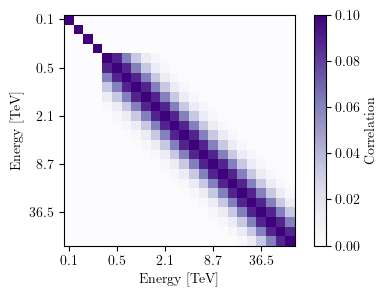

In [9]:
covmatrix = GaussianCovariance_matrix(magnitude=magnitude,
                    corrlength=corrlength,
                             size = len(setup.emask()))

fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(covmatrix.cov(), vmin = 0, vmax = 0.1,
               cmap = "Purples")
fig.colorbar(pos, ax=ax1)
ticks = [0,5,10,15,20]
energy_ticks = dataset_input.geoms['geom'].axes[0].center[ticks].value
energy_ticks = np.round(energy_ticks,1)
ax1.set_xticks(ticks)
ax1.set_xticklabels(energy_ticks)
ax1.set_yticks(ticks)
ax1.set_yticklabels(energy_ticks)
ax1.set_ylabel("Energy [TeV]")
ax1.set_xlabel("Energy [TeV]")
cbar = plt.gca().images[-1].colorbar
cbar.set_label('Correlation', rotation=90)

fig.savefig("plots/2_cov_matrix.pdf", bbox_inches="tight")
fig.savefig("plots/2_cov_matrix.png", bbox_inches="tight")



Text(0, 0.5, 'Systematic [\\%]')

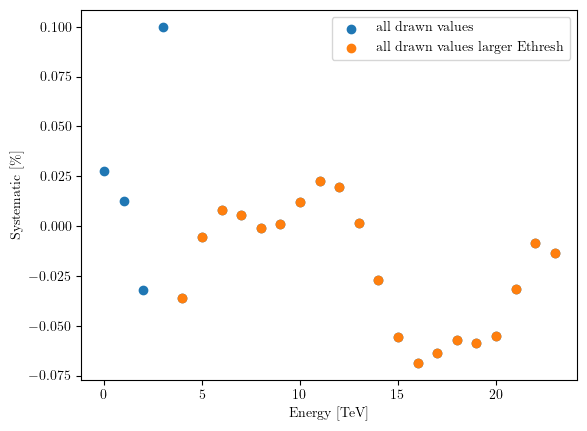

In [10]:
values = covmatrix.draw(seed = seed)
plt.scatter(range(24), values, label = "all drawn values")
plt.scatter(np.arange(24)[emask], values[emask], label = "all drawn values larger Ethresh")
plt.legend()
plt.xlabel("Energy [TeV]")
plt.ylabel("Systematic [\%]")

(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

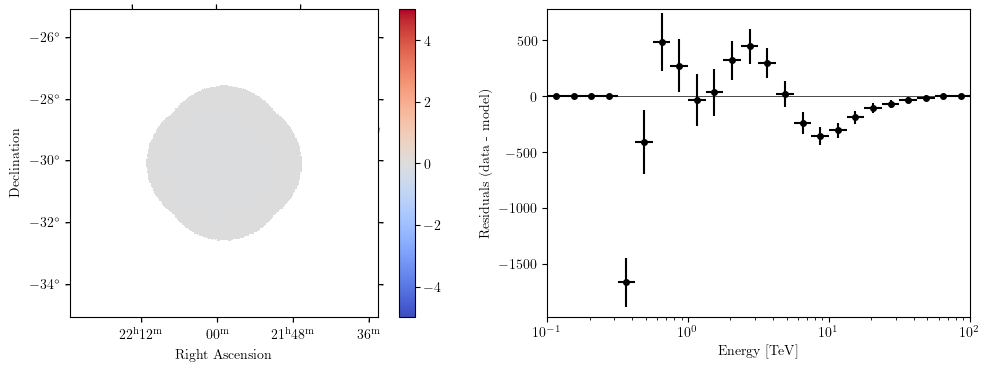

In [11]:
dataset_asimov.plot_residuals()

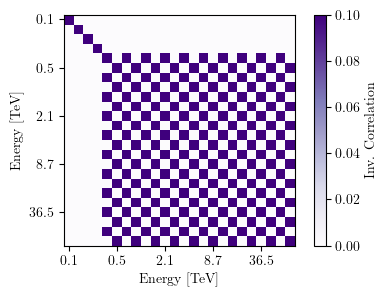

In [12]:
fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(dataset_asimov_N.models.parameters.prior[-1].covariance_matrix, vmin = 0, vmax = 0.1,
               cmap = "Purples")
fig.colorbar(pos, ax=ax1)
ticks = [0,5,10,15,20]
energy_ticks = dataset_input.geoms['geom'].axes[0].center[ticks].value
energy_ticks = np.round(energy_ticks,1)
ax1.set_xticks(ticks)
ax1.set_xticklabels(energy_ticks)
ax1.set_yticks(ticks)
ax1.set_yticklabels(energy_ticks)
ax1.set_ylabel("Energy [TeV]")
ax1.set_xlabel("Energy [TeV]")
cbar = plt.gca().images[-1].colorbar
cbar.set_label('Inv. Correlation', rotation=90)

fig.savefig("plots/2_inv_cov_matrix.pdf", bbox_inches="tight")
fig.savefig("plots/2_inv_cov_matrix.png", bbox_inches="tight")



## Fit

In [13]:
%%time
fit = Fit()
fit.run(dataset_asimov)

CPU times: user 12.2 s, sys: 2.8 s, total: 15 s
Wall time: 15 s


In [14]:
%%time
fit_sys = Fit()
fit_sys.run(dataset_asimov_N)

CPU times: user 1min 28s, sys: 34.8 s, total: 2min 3s
Wall time: 2min 4s


#### Best-Fit Systematic

NameError: name 'colors' is not defined

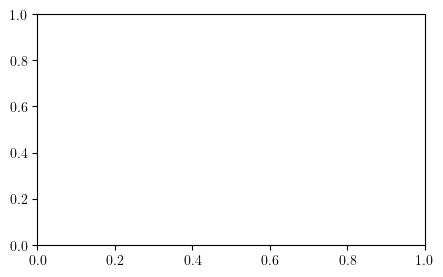

In [15]:
fig, ax = plt.subplots(figsize = (5,3))

values_fitted = dataset_asimov_N.models[1].spectral_model(energy)
plt.plot(energy.value[emask], 100 * values_fitted[emask]-100, color = colors[1],
        label = "Best-fit nuisance pars.")

#plt.fill_between(energy.value[emask], sys_percentage[emask],-sys_percentage[emask],
#                alpha = 0.1, color = 'tab:green')
plt.scatter(energy.value[emask], 100*values[emask], color = 'purple',
            marker = "+", s = 80,
           label = "Input")
plt.xscale('log')
plt.hlines(0, 0.4,100, color= 'grey')
plt.yscale("linear")
plt.ylim(-12,12)
plt.xlabel("Energy [TeV]")
plt.ylabel("Systematic [\%]")
plt.legend()
fig.savefig('plots/2_nui_sys_input.png', bbox_inches="tight")

In [ ]:
#### Spectral Residual Points

In [ ]:
fig, ax = plt.subplots(figsize = (5,3))
ax = dataset_asimov.plot_residuals_spectral(method =  'diff/sqrt(model)',
                                            color = colors[0], 
                                    label = "Without nuisance par.")
dataset_asimov_N.plot_residuals_spectral(method =  'diff/sqrt(model)',
                                         color =colors[1],
                                             label = "With nuisance par.",
                                        )

#plt.fill_between(energy.value, sys_percentage[emask],-sys_percentage[emask],alpha = 0.3)
ax.legend()
ax.set_xlim(0.4,100)
ax.set_ylim(-10,10)

plt.tight_layout()

lim = ax.get_ylim()
ax.set_ylim(-np.max(np.abs(lim)), np.max(np.abs(lim)))
fig = plt.gcf()
fig.savefig('plots/2_spectracl_res_points_diff.png')

In [ ]:
fig, ax = plt.subplots(figsize = (5,3))
ax = dataset_asimov_N.plot_residuals_spectral(method =  'diff', color = 'tab:blue',
                                             label = "Asimov Fit w/o nui.", marker = 'x',
                                             capsize = 3)
dataset_asimov.plot_residuals_spectral(method =  'diff', color = 'tab:red', ax = ax,
                                    label = "Asimov Fit w/ nui.",marker = 'o',
                                      capsize = 3)
#plt.fill_between(energy.value, sys_percentage[emask],-sys_percentage[emask],alpha = 0.3)
ax.legend()
ax.set_xlim(0.315,100)
plt.tight_layout()
lim = ax.get_ylim()
ax.set_ylim(-np.max(np.abs(lim)), np.max(np.abs(lim)))
fig = plt.gcf()
fig.savefig('plots/2_spectracl_res_points.png')
fig.savefig('plots/2_spectracl_res_points.pdf')

#### Best-Fit Parameters

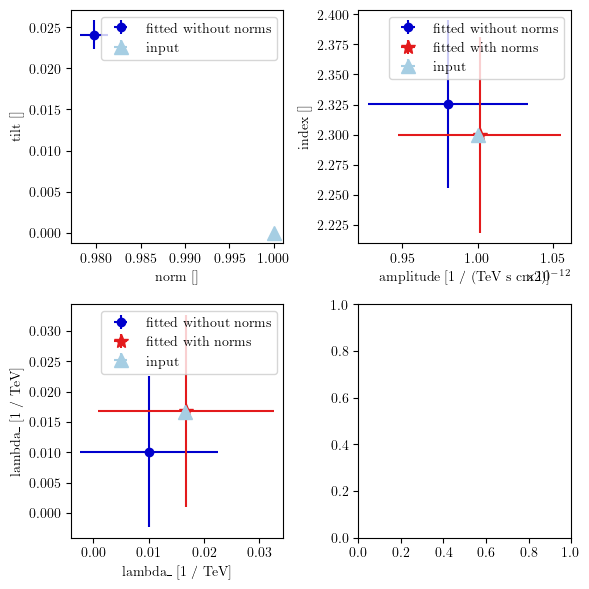

In [19]:
models_list = [ dataset_asimov.models, dataset_asimov_N.models , dataset_input.models]
labels = [ 'fitted without norms','fitted with norms', 'input']
fmts = ['o','*', '^', ]

pars =  pars = [('norm', 'tilt'),('amplitude', 'index'),
               ('lambda_', 'lambda_')]
ax = plot_source_par(0, pars)


In [20]:
for p in ['amplitude', 'index', 'lambda_']:
    print(p)
    for i, d in enumerate([dataset_asimov, dataset_asimov_N, dataset_input]):
        pp = d.models[0].parameters[p]
        print(f"{labels[i]}")
        if p == 'lambda_':
            print(f"$1/{(1/pp.value):.3} \pm 1/{(pp.error/pp.value**2):.3}$")   
        if p == 'amplitude':
            print(f"${pp.value*1e12:.2} \pm {pp.error*1e12:.2}$")   
            
        else:
            print(f"${pp.value:.4} \pm {pp.error:.4}$")   
        
    print()

amplitude
fitted without norms
$0.98 \pm 0.053$
fitted with norms
$1.0 \pm 0.054$
input
$1.0 \pm 0.0$

index
fitted without norms
$2.325 \pm 0.06955$
fitted with norms
$2.3 \pm 0.08099$
input
$2.3 \pm 0.0$

lambda_
fitted without norms
$1/99.0 \pm 1/1.22e+02$
$0.0101 \pm 0.01242$
fitted with norms
$1/59.5 \pm 1/56.1$
$0.0168 \pm 0.01584$
input
$1/60.0 \pm 1/0.0$
$0.01667 \pm 0.0$



## Fluxpoints

In [21]:
comput_fp = 0
if comput_fp :
    energy_edges = dataset_asimov.geoms["geom"].axes[0].edges[::2]
    esti = FluxPointsEstimator(energy_edges=energy_edges)
    fluxpoints = esti.run([dataset_asimov])
    fluxpoints.write(
        "data/fluxpoints/2_fluxpoints_asimov.fits", overwrite = True
    )
    Models([dataset_asimov.models[0]]).write(
        "data/fluxpoints/2_model_asimov.fits" , overwrite = True
    )
    
    fluxpoints_N = esti.run([dataset_asimov_N])
    fluxpoints_N.write(
        f"data/fluxpoints/2_fluxpoints_asimov_N.fits", overwrite= True,
    )
    Models([dataset_asimov_N.models[0]]).write(
        f"data/fluxpoints/2_model_asimov_N.fits", overwrite= True,
    )
    
    fp_asimov = FluxPointsDataset(data = fluxpoints, models = Models([dataset_asimov.models[0]]))
    fp_asimov_N = FluxPointsDataset(data = fluxpoints_N, models = Models([dataset_asimov_N.models[0]]))
    
else:
    fp_asimov = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov.fits"),
                                 models = Models.read("data/fluxpoints/2_model_asimov.fits"))
    fp_asimov_N = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov_N.fits"),
                                 models = Models.read("data/fluxpoints/2_model_asimov_N.fits"))

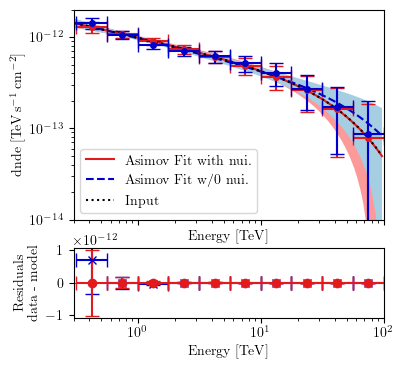

In [22]:
fp_asimov = FluxPointsDataset(
    data=FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov.fits"),
    models=Models.read("data/fluxpoints/2_model_asimov.fits"),
)
fp_asimov_N = FluxPointsDataset(
    data=FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov_N.fits"),
    models=Models.read("data/fluxpoints/2_model_asimov_N.fits"),
)


energy_power = 2
fig, axs = plt.subplots(2, 1, figsize=(4, 4), sharex=True, gridspec_kw={"height_ratios": [3, 1]},)
plot_asimov_spectrum(fig, axs[0])
fp_asimov_N.data.plot(energy_power=2, color=colors[1], ax=axs[0], capsize = 5)
fp_asimov.data.plot(energy_power=2, color=colors[0], ax=axs[0], capsize = 5)


fp_asimov.plot_residuals(ax =axs[1], color = colors[0], capsize = 5, marker = 'x')
fp_asimov_N.plot_residuals(ax =axs[1], color = colors[1],  capsize = 5, marker = 'o')

axs[0].set_xlim(0.3, 100)
fig.savefig("plots/2_fluxpoints_spectrum.pdf", bbox_inches="tight")
fig.savefig("plots/2_fluxpoints_spectrum.png", bbox_inches="tight")

## Corelation Matrix

<Axes: >

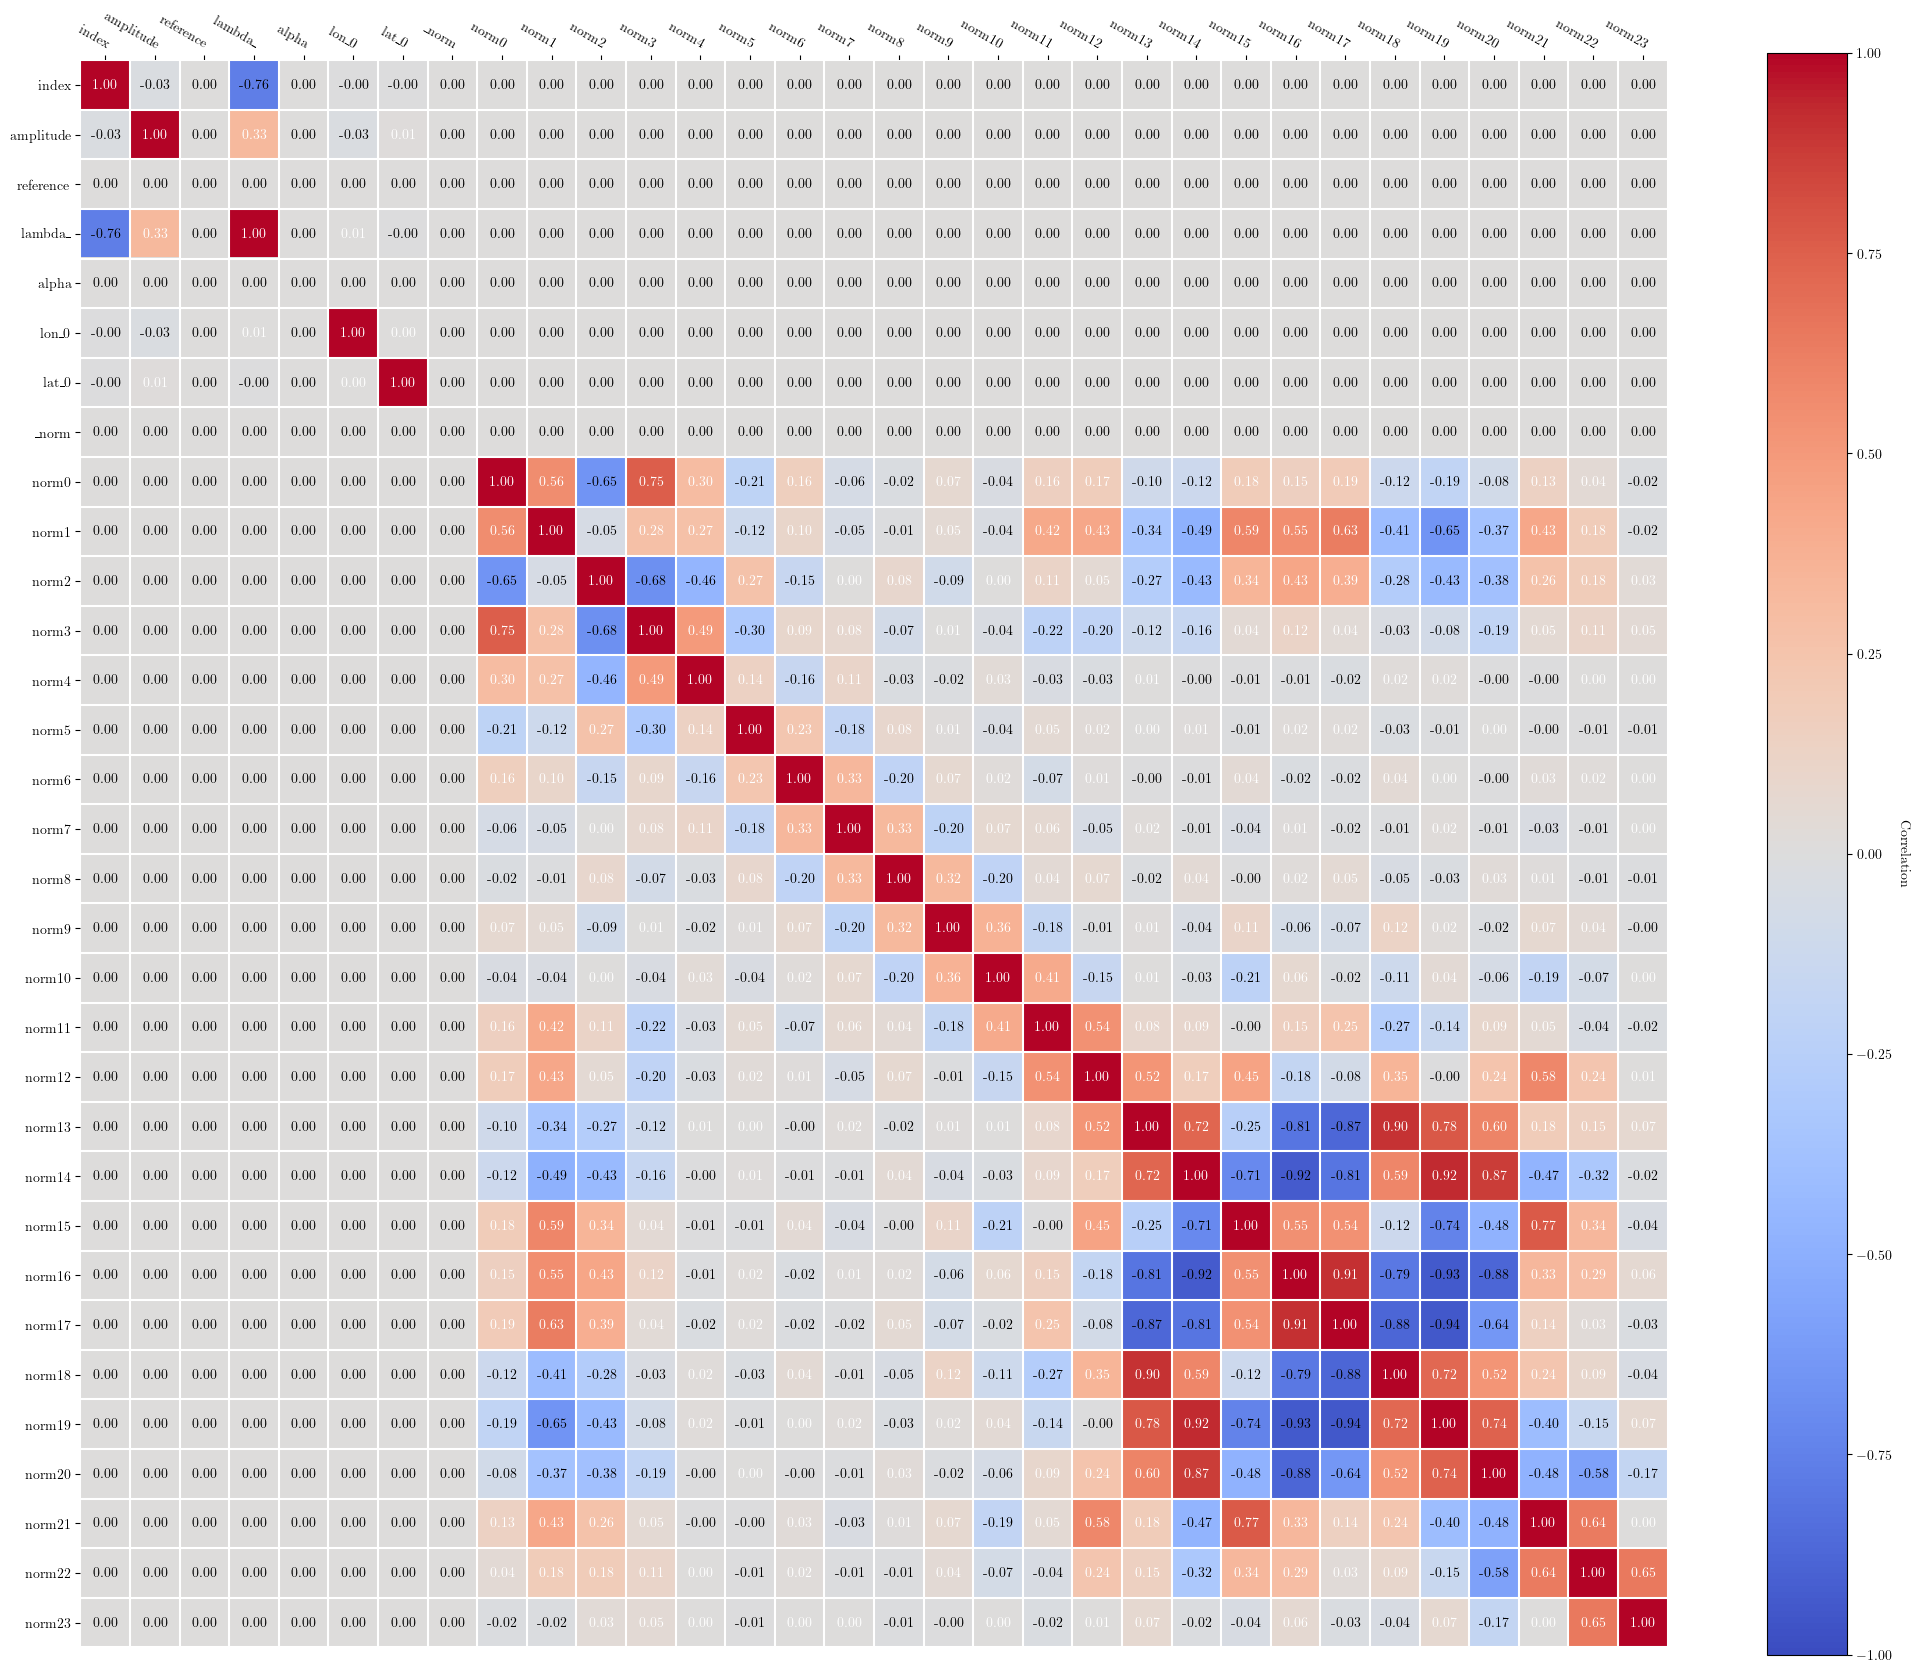

In [23]:
dataset_asimov_N.models.covariance.plot_correlation()